# Final Report - Clustering Project

Nathan Sharick - Innis Cohort

---

### Project Description:
- This project is a continuation of the regression project focused on analyzing the Zillow dataset. For this project the target was analyzing divers of logerror (error in the zestimate home price prediction) using visualizations, statistical testing, clustering machinging learning models and regression machine learning models. 

### Project Goals:
- Goal 1: Identify features that are related to logerror using visualizations and statistical testing

- Goal 2: Identify feature relationships and feature groups using clustering machine learning models

- Goal 3: Use features and feature clusters identified during exploration to develop a regression machine learning model to predict the logerror for a property

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from scipy import stats
import math
from wrangle_zillow import acquire_zillow
from wrangle_zillow import missing_col_values
from wrangle_zillow import missing_row_values
from wrangle_zillow import single_unit_properties
from wrangle_zillow import data_prep
from wrangle_zillow import split_data
from wrangle_zillow import remove_outliers
from wrangle_zillow import split_by_region
from wrangle_zillow import lr_model_prep
from wrangle_zillow import cluster_model_prep
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


### Acquire, Clean, Split, and Wrangle the dataset
- This notebook uses multiple functions located in the acompanying wrangle_zillow.py file to acquire, clean, split, and wrangle the Zillow dataset for this project.

- The acquire_zillow function checks to see if there is a copy of the dataset stored localy as a .csv file. If there is one it will read the dataset in from the file. If there is not a local copy it will use a sql query to pull a copy of the dataset fron the CodeUp database. The query pulls data from the most recent sale of each property that was sold in 2017 and that includes latitude and longitude data.

- The single_unit_properties function takes in the dataframe and filters out any property that is not a single family residence, a mobile home, a cluster home, or a manufactures home and also filters out properties that have a unit count value of more than one.

- The data_prep function prepares the dataframe by first removeing columns that have more than 50% null values and then removes remaining rows with more than 75% null values. Lastly it fills null values in the unit count column with '1' since multi-unit properties have been filtered out, and it fills in missing structure values by subtracting the land value from the overall property value. 

- The split_data function splits the dataset by rows into three parts (train, validate, and test) so that the data exploration, model development, and model training can be done with the train set, then the models can be evaluated with a new set of observations (validate), and the final machine learning model can be tested with the third set of observaitons (test) this helps prevent overfitting the model and helps the model accurately generalize to new data moving forward. This function splits the data into 80% for the train/validate set and 20% for the test set then splits the train/validate set into 70% for train and 30% for validate

- The remove_outliers function calculates the interquartile range for each set of feature values and removes rows with values outside of that range (greater than the upper bound and less than the lower bound).

- The code cell below runs all these functions and outputs a clean dataset ready for exploration

In [2]:
#acquire the zillow dataset with the acquire_zillow function
df = acquire_zillow()
#filter out only single unit properties using the single_unit_properties function
df = single_unit_properties(df)
#identify un needed columns from the dataframe
remove_cols = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc']
#remove above identified columns and columns/rows with significant null value counts
df = data_prep(df, cols_to_remove=remove_cols, prop_required_column=.5, prop_required_row=.75)
#split the data into train, validate, and test sets to prevent overfitting and data leakage
train, validate, test = split_data(df)
#identify columns to remove outliers from
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#remove outliers from the specified column with the remove_outliers function
train = remove_outliers(train, 1.5, out_columns)

Reading from csv file...


### Explore Variable Interactions with Visualizations and Statistical Testing
- In this section each of the primary features found in the zillow dataset will be compared to the logerror of the property to evaluate their relationship with the target variable

- Each feature will be evaluated with visualizations and with statistical tests to look at their relationship as a driver of the propety's logerror.

- The features evaluated in the initial data exploration include, the number of bathrooms a property has, the number of bedrooms a property has, the property's square footage, and the location of the property using latitude and longitude data.

**Question 1:** Is the square footage of the home related to the logerror for the property?

**Visualization**

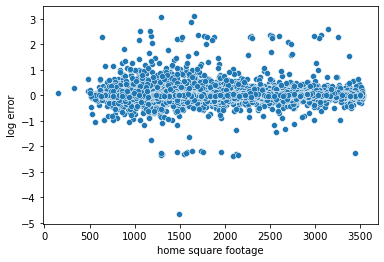

In [47]:
#visualize the square footage of the home against the logerror for the property using a scatter plot
sns.scatterplot(x="calculatedfinishedsquarefeet", y="logerror", data=train)
plt.xlabel("home square footage")
plt.ylabel("log error")
plt.show()

**Statistical Testing**

Hypothesis:

- H0= The square footage of the home is not related to the logerror for the property

- Ha= The square footage of the home is related to the logerror for the property

In [4]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.calculatedfinishedsquarefeet
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.01345112500446546 P-Value = 0.029782946539496435
-----------------------------------
We reject the null hypothesis


**Question 2:** Is the number of bathrooms the home has related to the logerror for the property?

**Visualization**

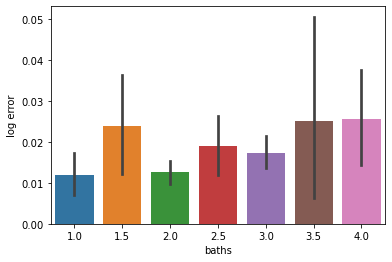

In [5]:
#visualize the number of bathrooms that a home has against the logerror for the property using a barplot
sns.barplot(x="bathroomcnt", y="logerror", data=train)
plt.xlabel("baths")
plt.ylabel("log error")
plt.show()

**Statistical Testing**

Hypothesis:

- H0= The number of bathrooms a home has is not related to the logerror for the property

- Ha= The number of bathrooms a home has is related to the logerror for the property

In [6]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.bathroomcnt
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.015931904262757063 P-Value = 0.010059711283207814
-----------------------------------
We reject the null hypothesis


**Question 3:** Is the number of bedrooms a home has related to the logerror for the property

**Visualization**

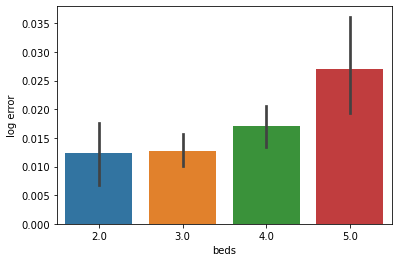

In [7]:
#visualize the number of bedrooms a home has against the logerror for the property
sns.barplot(x="bedroomcnt", y="logerror", data=train)
plt.xlabel("beds")
plt.ylabel("log error")
plt.show()

**Statistical Testing**

Hypothesis:

- H0= The number of bathrooms a home has is not related to the logerror for the property

- Ha= The number of bathrooms a home has is related to the logerror for the property

In [8]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.bedroomcnt
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.0182726424149222 P-Value = 0.0031575247715086353
-----------------------------------
We reject the null hypothesis


**Question 4:** Is the location of the property (latitude) related to the logerror for the property?

**Visualization**

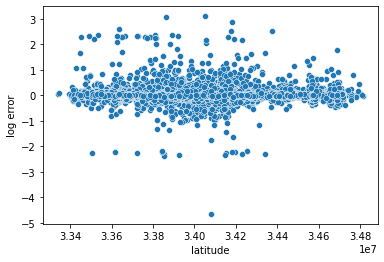

In [9]:
#visualize latitude data for the home's location against the logerror for the property using a scatterplot
sns.scatterplot(x="latitude", y="logerror", data=train)
plt.xlabel("latitude")
plt.ylabel("log error")
plt.show()

**Statistical Testing**

Hypothesis:

- H0= The location of a property (latitude) is not related to the logerror for the property?

- Ha= The location of a property (latitude) is related to the logerror for the property?

In [10]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.latitude
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = -0.016678118482840593 P-Value = 0.007052903217613151
-----------------------------------
We reject the null hypothesis


**Question 5:** Is the location of the property (longitude) related to the logerror for the property?

**Visualization**

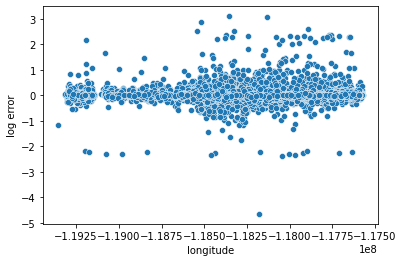

In [11]:
#visualize longitude data for the home's location against the logerror for the property using a scatterplot
sns.scatterplot(x="longitude", y="logerror", data=train)
plt.xlabel("longitude")
plt.ylabel("log error")
plt.show()

**Statistical Testing**

Hypothesis:

- H0= The location of a property (longitude) is not related to the logerror for the property?

- Ha= The location of a property (longitude) is related to the logerror for the property?

In [12]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.longitude
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.022473512518182796 P-Value = 0.00028256268153665446
-----------------------------------
We reject the null hypothesis


### Key Takeaways from initial exploration:

- Bedroom and bathroom count and the square footage of the property were all found to be correlated with the logerror for the property as well as the home price which was seen during the earlier regression project. 

- While the year the home was built was correlated with home price, it was not correlated with the logerror for the property

- The location of the home based on latitude and longitude data was also found to be correlated with the logerror for the property.

### Preparing the Dataset for Exploration with Clustering Models

- After the initial data exploration was completed the dataset needed further preparation prior to exploration using clustering machine learning models

- The acquire_zillow, single_unit_properties, and data_prep functions are used again here to pull a fresh copy of the dataset into the notebook so it can be run from top down.

- Since it was found that the splitting the dataset into three datasets by region improved the performance of the model during the regression project, the same strategy was used here. The split_by_region function takes the dataset and splits it into three datasets using the property's fips code representing one of three counties in California, Los Angeles county, Orange county, or Ventura county.

- Since the location of the property was found to be correlated with the logerror for the property I wanted to take the location variable further once the dataset was split by county. For each county I located the central or most popular beach and looked up its latitude and longitude coordinates using Google maps. I then used that information to calculate the distance of the property from the beach and added new columns to the dataframe with the distance values. Beaches by county were:
    - Los Angeles County = Santa Monica Beach - lat/long = 34012355 / -118498665
    - Orange County = Huntington Beach - lat/long = 33640954 / -117978893
    - Ventura County = San Buenaventura Beach - lat/long = 34267111 / -119278788

- Since the original dataset was split into three datasets I used the split_data and remove_outliers functions to complete the data preparation on each of the three individually.

- Lastly I used the cluster_model_prep function to scale the x and y variable columns using a min-max scaler and stored those values in a new dataframe to use in clustering models

In [13]:
#acquire a fresh copy of the dataset for clustering models with the acuire_zillow function
df = acquire_zillow()
#filter the dataset for single unit properties
df = single_unit_properties(df)
#Identify unneeded columns from the dataframe
remove_cols = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc']
#remove identified columns and columns/rows with significant null values using the data_prep function
df = data_prep(df, cols_to_remove=remove_cols, prop_required_column=.5, prop_required_row=.75)
#split the dataframe into three dataframes by region (fips code) using the split by region function
df1, df2, df3 = split_by_region(df)
#add new columns to each of the three regional dataframes that contain 
#distance from the beach values for each property
df1['dist_lat'] = df1.latitude - 34012355
df1['dist_long'] = df1.longitude - (-118498665)
df2['dist_lat'] = df2.latitude - 33640954
df2['dist_long'] = df2.longitude - (-117978893)
df3['dist_lat'] = df3.latitude - 34267111
df3['dist_long'] = df3.longitude - (-119278788)

Reading from csv file...


In [14]:
#split each of the three regional dataframes into train, validate and test sets 
#to prevent overfitting and data leakage
train1, validate1, test1 = split_data(df1)
train2, validate2, test2 = split_data(df2)
train3, validate3, test3 = split_data(df3)
#Identify columns that outliers need to be removed from 
out_cols = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#remove outliers from each of the three regional dataframes individually
train1 = remove_outliers(train1, 1.5, out_cols)
train2 = remove_outliers(train2, 1.5, out_cols)
train3 = remove_outliers(train3, 1.5, out_cols)
#use the cluster_model_prep function to scale the data from the chosen variables and 
#store them in a seperate dataframe for use with cluster modeling
#this is done for train, validate, and test for all three regional dataframes
#so clusters can be developed with all the datasets for future regression modeling 
#and testing of the best performing model
cluster_df1_train = cluster_model_prep(train1)
cluster_df1_val = cluster_model_prep(validate1)
cluster_df1_test = cluster_model_prep(test1)
cluster_df2_train = cluster_model_prep(train2)
cluster_df2_val = cluster_model_prep(validate2)
cluster_df2_test = cluster_model_prep(test2)
cluster_df3_train = cluster_model_prep(train3)
cluster_df3_val = cluster_model_prep(validate3)
cluster_df3_test = cluster_model_prep(test3)

### Exploring the Dataset with Clustering Models

- Clustering models were used with three sets of features to look at variable interactions and grouping and then those clusters of datapoints were compared to each other using the mean logerror for the group.

- Feature group 1 = bedroom count, bathroom count, square footage of home

- Feature group 2 = latitude and longitude of the property

- Feature group 3 = Distance from the beach using latitude and longitude

- The optimal quantity of clusters for each model was determined using a for loop to loop through cluster values from 2 to 11, and evaluating the resulting inertia for each model.

- All cluster models were ran with the train, validate, and test for each of the three dataframes so that all the resulting cluster groups were available for further evaluation as features for regression models but only clusters with the train data were used for visualizations and mean error comparisons during exploration

**Cluster Model 1:** bedroom count, bathroom count, and squarefootage of the home

In [15]:
#dataframe 1 - Los Angeles County Properties
#train clusters
#identify the features to be used for cluster modeling
x = cluster_df1_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
#create the kmeans clustering object
kmeans = KMeans(n_clusters=3, random_state=123)
#fit the kmeans object with the chose variables
kmeans.fit(x)
#make predictions with the clustering model and 
#create a new column in the original dataframe with the resulting cluster group values
train1['bedbathsqft_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df1_val[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
validate1['bedbathsqft_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df1_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
test1['bedbathsqft_cluster'] = kmeans.predict(x)

#dataframe 2 - Orange County Proerties
#train clusters
x = cluster_df2_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
train2['bedbathsqft_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df2_val[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
validate2['bedbathsqft_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df2_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
test2['bedbathsqft_cluster'] = kmeans.predict(x)

#dataframe 3 - Ventura County Propertues
#train clusters
x = cluster_df3_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
train3['bedbathsqft_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df3_val[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
validate3['bedbathsqft_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df3_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
test3['bedbathsqft_cluster'] = kmeans.predict(x)

**Visualize Cluster model 1**

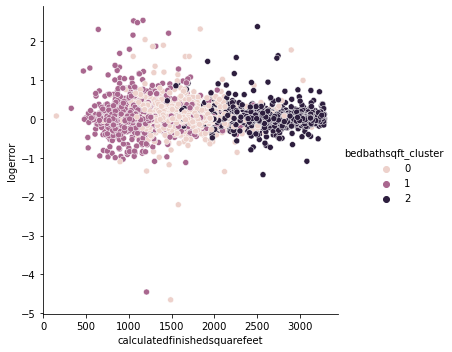

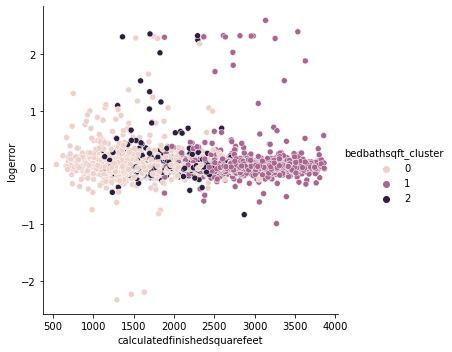

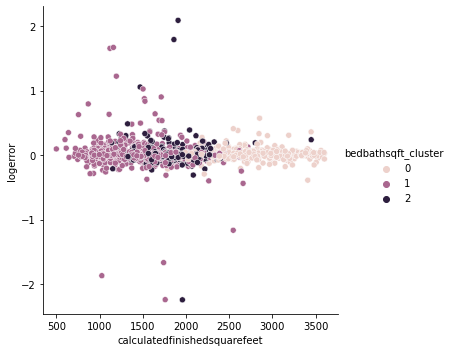

In [44]:
#plot clustering model 1 with the home's square footage as the x axis and logerror as the y axis because 
#they are both continuous variable and provide the most useful/readable visualization 
#of the cluster's relationship to logerror

#visualization for Los Angeles County Properties
sns.relplot(data=train1, y='logerror', x='calculatedfinishedsquarefeet', hue='bedbathsqft_cluster')
#visualization for Orange County Properties
sns.relplot(data=train2, y='logerror', x='calculatedfinishedsquarefeet', hue='bedbathsqft_cluster')
#visualization for Ventura County properties
sns.relplot(data=train3, y='logerror', x='calculatedfinishedsquarefeet', hue='bedbathsqft_cluster')
#output the visualizations
plt.show()

**Evaluate the model by comparing mean error for each cluster**

In [51]:
#Los Angeles County Properties
#seperate the rows in the first cluster
clust_1 = train1[train1['bedbathsqft_cluster']== 0]
#seperate the rows in the second cluster
clust_2 = train1[train1['bedbathsqft_cluster']== 1]
#seperate the rows in the third cluster
clust_3 = train1[train1['bedbathsqft_cluster']== 2]
print('cluster 1 log error means for Los Angeles County:')
#output the mean log error for each of the cluster groups
print(clust_1.logerror.mean(), clust_2.logerror.mean(), clust_3.logerror.mean())
print('---------------------------------------------')
print('')

#Orange County Properties
#seperte the rows in the first cluster
clust_4 = train2[train2['bedbathsqft_cluster']== 0]
#seperate the rows in the second cluster
clust_5 = train2[train2['bedbathsqft_cluster']== 1]
#seperate the rows in the third cluster
clust_6 = train2[train2['bedbathsqft_cluster']== 2]
print('Cluster 1 log error means for Orange County:')
#output the mean log error for each of the cluster groups
print(clust_4.logerror.mean(), clust_5.logerror.mean(), clust_6.logerror.mean())
print('---------------------------------------------')
print('')

#Ventura County Properties
#seperate rows in the first cluster
clust_7 = train3[train3['bedbathsqft_cluster']== 0]
#seperate rows in the second cluster
clust_8 = train3[train3['bedbathsqft_cluster']== 1]
#separate the rows in the third cluster
clust_9 = train3[train3['bedbathsqft_cluster']== 2]
print('Cluster 1 log error means for Ventura County:')
#output the mean log error for each of the cluster groups
print(clust_7.logerror.mean(), clust_8.logerror.mean(), clust_9.logerror.mean())


cluster 1 log error means for Los Angeles County:
0.012245427364873072 0.011631384360596693 0.015963774955930522
---------------------------------------------

Cluster 1 log error means for Orange County:
0.022335034111095664 0.0347695345758422 0.027717877271435973
---------------------------------------------

Cluster 1 log error means for Ventura County:
0.01035804241046321 0.012499964854866282 0.019048492539035507


**Cluster 2:** latitude and longitude of the property

In [18]:
#dataframe 1 - Los Angeles County Properties
#train clusters
#identify the features to be used for cluster modeling
x = cluster_df1_train[['latitude', 'longitude']]
#create the kmeans clustering object
kmeans = KMeans(n_clusters=4, random_state=123)
#fit the kmeans object with the chose variables
kmeans.fit(x)
#make predictions with the clustering model and 
#create a new column in the original dataframe with the resulting cluster group values
train1['latlong_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df1_val[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate1['latlong_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df1_test[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test1['latlong_cluster'] = kmeans.predict(x)

#dataframe 2 - Orange County Properties
#train clusters
x = cluster_df2_train[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train2['latlong_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df2_val[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate2['latlong_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df2_test[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test2['latlong_cluster'] = kmeans.predict(x)

#dataframe 3 - Ventura County properties
#train clusters
x = cluster_df3_train[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train3['latlong_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df3_val[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate3['latlong_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df3_test[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test3['latlong_cluster'] = kmeans.predict(x)

**Visualize cluster model 2**

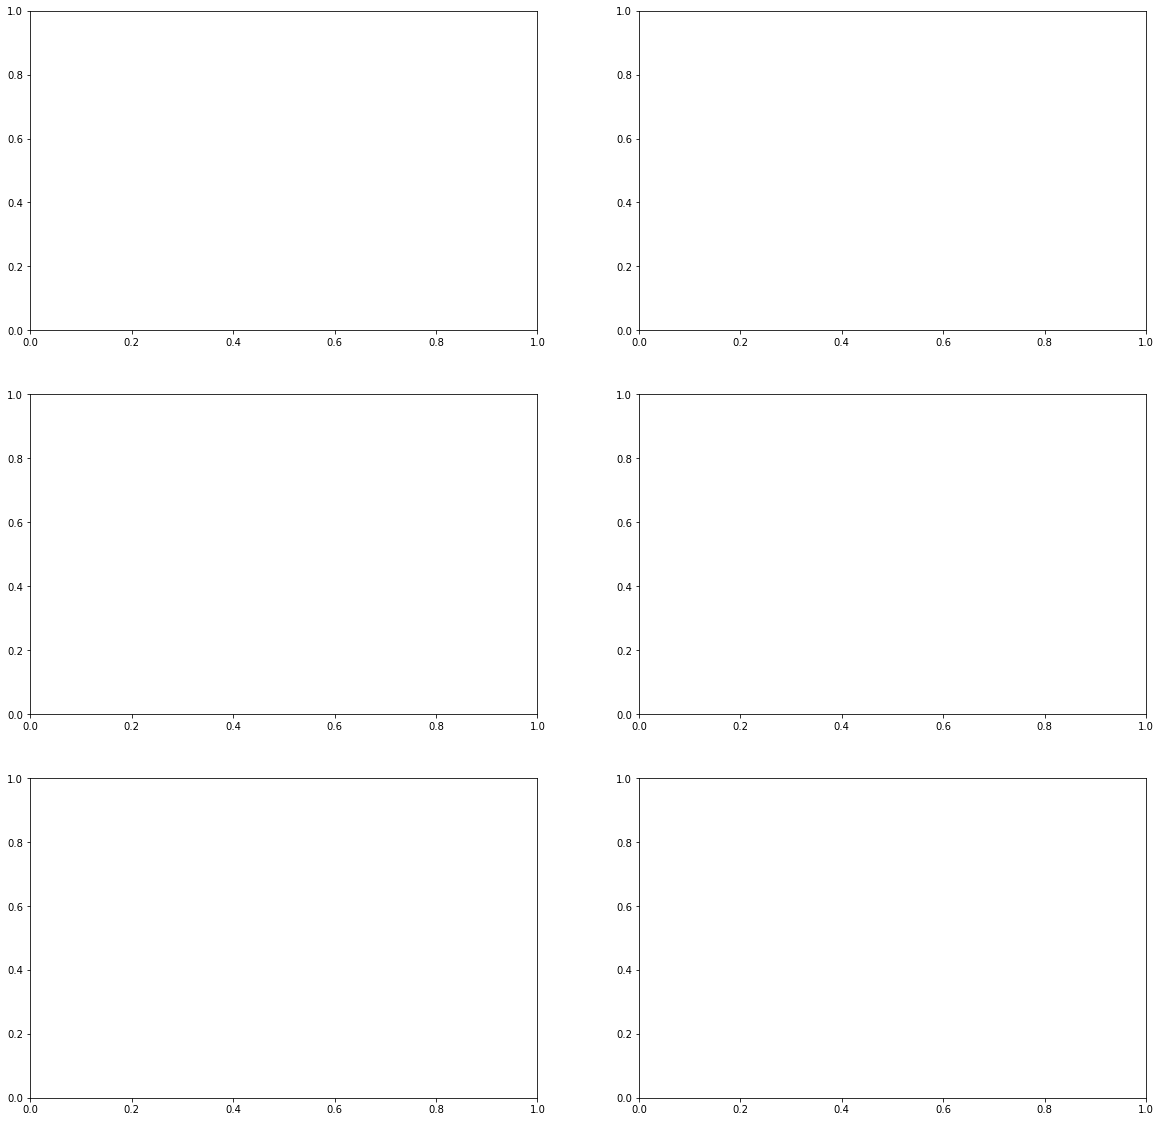

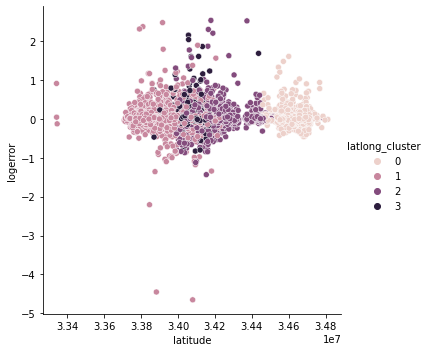

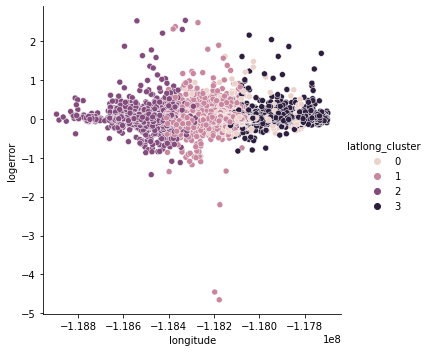

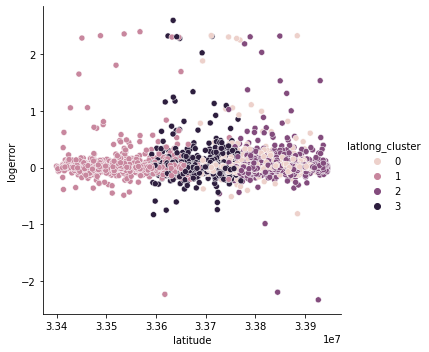

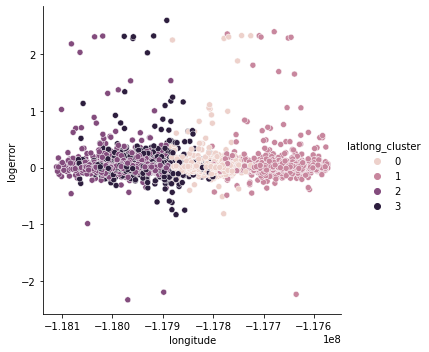

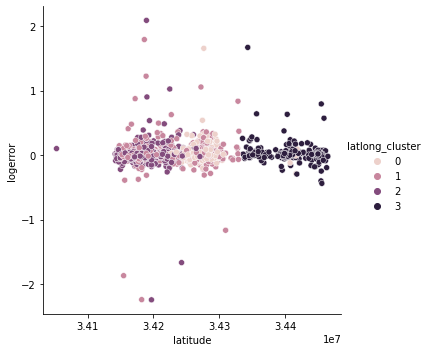

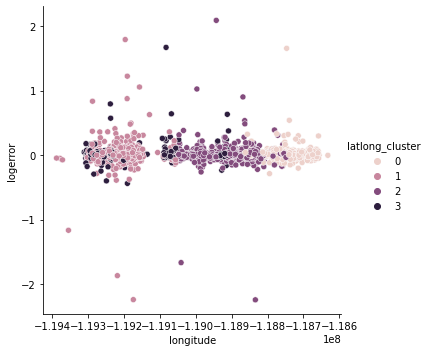

In [40]:
#visualize cluster 2 by creating pairs of plots to show latitude and longitude plotted against logerror
#for each regional dataset
fig, ax= plt.subplots(nrows=3, ncols=2, figsize=(20,20))
#visualizations for Los Angeles County
sns.relplot(data=train1, y='logerror', x='latitude', hue='latlong_cluster', ax=ax[0,0])
sns.relplot(data=train1, y='logerror', x='longitude', hue='latlong_cluster', ax=ax[0,1])
#visualizations for Orange County
sns.relplot(data=train2, y='logerror', x='latitude', hue='latlong_cluster', ax=ax[1,0])
sns.relplot(data=train2, y='logerror', x='longitude', hue='latlong_cluster', ax=ax[1,1])
#visualizations for Ventura county
sns.relplot(data=train3, y='logerror', x='latitude', hue='latlong_cluster', ax=ax[2,0])
sns.relplot(data=train3, y='logerror', x='longitude', hue='latlong_cluster', ax=ax[2,1])


**Evaluate the model by comparing mean error for each cluster**

In [52]:
#Los Angeles County Properties
#seperate the rows in the first cluster group
clust_1 = train1[train1['latlong_cluster']== 0]
#seperate rows in the second cluster group
clust_2 = train1[train1['latlong_cluster']== 1]
#seperate rows in the third cluster group
clust_3 = train1[train1['latlong_cluster']== 2]
#seperate rows in the fourth cluster group
clust_4 = train1[train1['latlong_cluster']== 3]
print('Cluster 2 log error means for Los Angeles County:')
#output the mean logerror for each cluster group
print(clust_1.logerror.mean(), clust_2.logerror.mean(), clust_3.logerror.mean(), clust_4.logerror.mean())
print('---------------------------------------------')
print('')

#Orange County Properties
#seperate the rows in the first cluster group
clust_5 = train2[train2['latlong_cluster']== 0]
#seperate rows in the second cluster group
clust_6 = train2[train2['latlong_cluster']== 1]
#seperate rows in the third cluster group
clust_7 = train2[train2['latlong_cluster']== 2]
#seperate rows in the fourth cluster group
clust_8 = train2[train2['latlong_cluster']== 3]
print('df2 log error means:')
#output the mean logerror for each cluster group
print(clust_5.logerror.mean(), clust_6.logerror.mean(), clust_7.logerror.mean(), clust_8.logerror.mean())
print('---------------------------------------------')
print('')

#Ventura County Properties
#seperate the rows in the first cluster group
clust_9 = train3[train3['latlong_cluster']== 0]
#seperate rows in the second cluster group
clust_10 = train3[train3['latlong_cluster']== 1]
#seperate rows in the third cluster group
clust_11 = train3[train3['latlong_cluster']== 2]
#seperate rows in the fourth cluster group
clust_12 = train3[train3['latlong_cluster']== 3]
print('df3 log error means:')
#output the mean logerror for each cluster group
print(clust_9.logerror.mean(), clust_10.logerror.mean(), clust_11.logerror.mean(), clust_12.logerror.mean())


Cluster 2 log error means for Los Angeles County:
0.015796326572379085 0.007643095771413721 0.012097874293148922 0.022667997893309817
---------------------------------------------

df2 log error means:
0.02529658974042769 0.028111680773804434 0.023745703452340953 0.031005645484498745
---------------------------------------------

df3 log error means:
0.013271341109057902 0.012130095165214409 0.010842116153012279 0.030573685356601217


**Cluster Model 3:** Distance from the most popular beach (latitude and longitude)

In [21]:
#dataframe 1 - Los Angeles County Properties
#train clusters
#identify the features to be used in the clustering model
x = cluster_df1_train[['dist_lat', 'dist_long']]
#create the kmeans clustering object
kmeans = KMeans(n_clusters=4, random_state=123)
#fit the clustering object with the identified features
kmeans.fit(x)
#Make predictions with the trained model and add a column to the original dataframe with the resulting cluster groups
train1['dist_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df1_val[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate1['dist_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df1_test[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test1['dist_cluster'] = kmeans.predict(x)

#dataframe 2 - Orange County Properties
#train clusters
x = cluster_df2_train[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train2['dist_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df2_val[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate2['dist_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df2_test[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test2['dist_cluster'] = kmeans.predict(x)

#dataframe 3 - Ventura County properties
#train clusters
x = cluster_df3_train[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train3['dist_cluster'] = kmeans.predict(x)
#validate clusters
x = cluster_df3_val[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate3['dist_cluster'] = kmeans.predict(x)
#test clusters
x = cluster_df3_test[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test3['dist_cluster'] = kmeans.predict(x)


**Visualize cluster model 3**

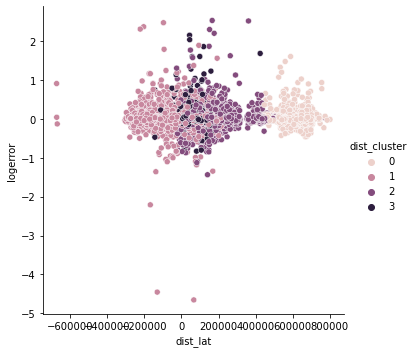

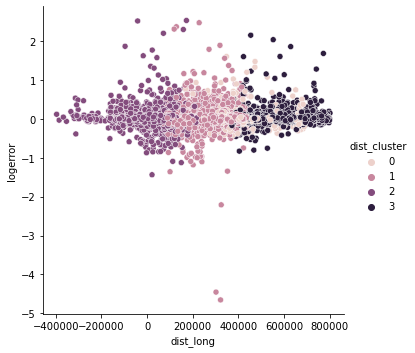

In [22]:
#visualize the distance from the beach in latitude and longitude against the logerror
#latitude visualization
sns.relplot(data=train1, y='logerror', x='dist_lat', hue='dist_cluster')
#longitude visualization
sns.relplot(data=train1, y='logerror', x='dist_long', hue='dist_cluster')
plt.show()

### Key Takeaways from Exploration with Clustering

- Valuable groupings of datapoints were found with the bedroom count/bathroom count/squarefootage cluster and with the  latitude / longitude cluster and both will be used for developing regression models.

- While understanding the property's distance from the beach was an interesting and possibly important variable to evaluate, when the values were scaled for use with a clustering model they produced the same values as the original latitude and longitude of the property so the clusters were the same for both groups. The most interesting finding from clustering and visualizing the distance from the beach variables is how it changed the scale for the visualization and what that tells us. Since the distance variable produced both positive and negative values (before scaling for the model) when the clusters are visualized using the unscaled values for scales the location of the beach is represented by '0' on the x axis and in some of the groups the highest levels of variance in logerror was seen with properties that were closest to the beach. This is most apparent in the first of the two visualizations above this cell where the distance in latitude from the beach in Los Angeles County is plotted against the logerror. In that visualization you can see that the closer the property is to the beach the larger the logerror is in both positive and negative directions. This represents an area for further exploration.

### Prepare the dataset for Linear Regression Modeling

- The dataframe needed some additional preparation prior to regression modeling to make it possible to include the above cluster groups as features in model development.

- The lr_model_prep function takes the dataframes created during the clustering modeling and concatinates the cluster grouping columns to the scaled variable columns. Then it encodes the cluster group columns so they can be used with regression models

In [23]:
#prepare the regional dataframes for regression modeling using the lr_model_prep function
#regional dataframe 1
lrmodel_train1_df = lr_model_prep(cluster_df1_train, train1)
lrmodel_val1_df = lr_model_prep(cluster_df1_val, validate1)
lrmodel_test1_df = lr_model_prep(cluster_df1_test, test1)
#regional dataframe 2
lrmodel_train2_df = lr_model_prep(cluster_df2_train, train2)
lrmodel_val2_df = lr_model_prep(cluster_df2_val, validate2)
lrmodel_test2_df = lr_model_prep(cluster_df2_test, test2)
#regional dataframe 3
lrmodel_train3_df = lr_model_prep(cluster_df3_train, train3)
lrmodel_val3_df = lr_model_prep(cluster_df3_val, validate3)
lrmodel_test3_df = lr_model_prep(cluster_df3_test, test3)

### Predictive Modeling - Linear Regression

- Multiple regression models were developed in an attempt to predict the logerror for the property, including multiple polynomial models, decision tree regressor models and k neighbors regressor models.

- Different combinations of clustered and non-clustered features and different hyperparameter combinations were used with each type of model to find the best performing model.

- Each model was ran with data from each of the three regional datasets individually

- The results of all the regression models in this notebook can be seen in the dataframe at the bottom of this section.

### Regression Model 1

- This model uses the best performing model from the regression project a 2 degree polynomial with only interactions and uses the scaled but not clustered features explored above including bathroom count, bedroom count, square footage of the home, latitude and longitude.

In [24]:
#regional dataframe 1
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_validate_features = validate1[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m2d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m2d1_predictions['baseline'] = validate1.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m2d1_predictions['polynomial D2 no clusters'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_4(y_predicted):
    return mean_squared_error(m2d1_predictions.actual, y_predicted)
#####################################################################
#regional dataframe 2
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_validate_features = validate2[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m2d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m2d2_predictions['baseline'] = validate2.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m2d2_predictions['polynomial D2 no clusters'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_5(y_predicted):
    return mean_squared_error(m2d2_predictions.actual, y_predicted)
##########################################################################
#regional dataframe 3
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_validate_features = validate3[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m2d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m2d3_predictions['baseline'] = validate3.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m2d3_predictions['polynomial D2 no clusters'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_6(y_predicted):
    return mean_squared_error(m2d3_predictions.actual, y_predicted)


### Regression Model 2

- This model uses a 5 degree polynomial model with only interactions and uses bathroom count, bedroom count, home square footage, and latitude / longitude clusters as features

In [25]:
#regional dataframe 1
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate1[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m3d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m3d1_predictions['baseline'] = validate1.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m3d1_predictions['polynomial D5 mixed features'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_7(y_predicted):
    return mean_squared_error(m3d1_predictions.actual, y_predicted)
###################################################################
#regional dataframe 2
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate2[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m3d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m3d2_predictions['baseline'] = validate2.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m3d2_predictions['polynomial D5 mixed features'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_8(y_predicted):
    return mean_squared_error(m3d2_predictions.actual, y_predicted)
####################################################################
#regional dataframe 3
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate3[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m3d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m3d3_predictions['baseline'] = validate3.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m3d3_predictions['polynomial D5 mixed features'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_9(y_predicted):
    return mean_squared_error(m3d3_predictions.actual, y_predicted)


### Regression Model 3

- This model uses a 5 degree polynomial model with only interactions and uses both the bathroom/bedroom/square footage clusters and the latitude / longitude clusters as features

In [26]:
#regional dataframe 1
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate1[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m4d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m4d1_predictions['baseline'] = validate1.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m4d1_predictions['polynomial D5 all cluster features'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_10(y_predicted):
    return mean_squared_error(m4d1_predictions.actual, y_predicted)
####################################################################
#regional dataframe 2
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate2[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m4d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m4d2_predictions['baseline'] = validate2.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m4d2_predictions['polynomial D5 all cluster features'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_11(y_predicted):
    return mean_squared_error(m4d2_predictions.actual, y_predicted)
###################################################################
#regional dataframe 3
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate3[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m4d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m4d3_predictions['baseline'] = validate3.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m4d3_predictions['polynomial D5 all cluster features'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_12(y_predicted):
    return mean_squared_error(m4d3_predictions.actual, y_predicted)


### Regression Model 4

- This model uses a decision tree regressor model with the bedroom / bathroom / square footage clusters and the latitude / longitude clusters as features since they were the best performing features on the polynomial models

In [27]:
#regional dataframe 1
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate1[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m5d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m5d1_predictions['baseline'] = validate1.logerror.mean()
#create the decision tree regressor object
dtr = DecisionTreeRegressor(random_state = 123)
#fit the model object with the identified features
dtr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
m5d1_predictions['decision tree regressor'] = dtr.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_13(y_predicted):
    return mean_squared_error(m5d1_predictions.actual, y_predicted)
##################################################################
#regional dataframe 2
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate2[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m5d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m5d2_predictions['baseline'] = validate2.logerror.mean()
#create the decision tree regressor object
dtr = DecisionTreeRegressor(random_state = 123)
#fit the model object with the identified features
dtr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
m5d2_predictions['decision tree regressor'] = dtr.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_14(y_predicted):
    return mean_squared_error(m5d2_predictions.actual, y_predicted)
##################################################################
#regional dataframe 3
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate3[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m5d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m5d3_predictions['baseline'] = validate3.logerror.mean()
#create the decision tree regressor object
dtr = DecisionTreeRegressor(random_state = 123)
#fit the model object with the identified features
dtr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
m5d3_predictions['decision tree regressor'] = dtr.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_15(y_predicted):
    return mean_squared_error(m5d3_predictions.actual, y_predicted)


### Regression Model 5

- This model uses a k neighbors regressor model with the bedroom / bathroom / square footage clusters and the latitude / longitude clusters as features since they were the best performing features on the polynomial models

In [28]:
#regional dataframe 1
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate1[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m6d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m6d1_predictions['baseline'] = validate1.logerror.mean()
#create the k neighbors regressor object
knr = KNeighborsRegressor(n_neighbors=5)
#fit the model object with the identified features
knr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
m6d1_predictions['KNN regressor'] = knr.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_16(y_predicted):
    return mean_squared_error(m6d1_predictions.actual, y_predicted)
###################################################################
#regional dataframe 2
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate2[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m6d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m6d2_predictions['baseline'] = validate2.logerror.mean()
#create the k neighbors regressor object
knr = KNeighborsRegressor(n_neighbors=5)
#fit the model object with the identified features
knr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
m6d2_predictions['KNN regressor'] = knr.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_17(y_predicted):
    return mean_squared_error(m6d2_predictions.actual, y_predicted)
####################################################################
#regional dataframe 3
#identify the x and y variable for the model from both the train and the validate datasets
x_train_features = lrmodel_train3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate3[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
m6d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with mean logerror
m6d3_predictions['baseline'] = validate3.logerror.mean()
#create the k neighbors regressor object
knr = KNeighborsRegressor(n_neighbors=5)
#fit the model object with the identified features
knr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
m6d3_predictions['KNN regressor'] = knr.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_18(y_predicted):
    return mean_squared_error(m6d3_predictions.actual, y_predicted)



### Results from Regression Modeling

- The code in the next cell was used to put the performance results for each of the regression models together so that all the models can be compared

- Results displayed are with the validate data for each dataset

- Performance of the models is displayed as root mean squared error and is read as the mean error of the models prediction from the actual values of logerror for the properties

- Since each model was ran with each of the three regional datasets the results are seperated by region with a column representing each

In [29]:
#create a dataframe with the results from regression model 1 with each of the regional datasets
a = pd.DataFrame(m2d1_predictions.apply(calculate_mse_4).apply(math.sqrt))
b = pd.DataFrame(m2d2_predictions.apply(calculate_mse_5).apply(math.sqrt))
c = pd.DataFrame(m2d3_predictions.apply(calculate_mse_6).apply(math.sqrt))
results = pd.concat([a, b, c], axis=1)
#create a dataframe with the results from regression model 2 with each of the regional datasets
d = pd.DataFrame(m3d1_predictions.apply(calculate_mse_7).apply(math.sqrt))
e = pd.DataFrame(m3d2_predictions.apply(calculate_mse_8).apply(math.sqrt))
f = pd.DataFrame(m3d3_predictions.apply(calculate_mse_9).apply(math.sqrt))
results2 = pd.concat([d, e, f], axis=1)
#create a dataframe with the results from regression model 3 with each of the regional datasets
g = pd.DataFrame(m4d1_predictions.apply(calculate_mse_10).apply(math.sqrt))
h = pd.DataFrame(m4d2_predictions.apply(calculate_mse_11).apply(math.sqrt))
i = pd.DataFrame(m4d3_predictions.apply(calculate_mse_12).apply(math.sqrt))
results3 = pd.concat([g, h, i], axis=1)
#create a dataframe with the results from regression model 4 with each of the regional datasets
j = pd.DataFrame(m5d1_predictions.apply(calculate_mse_13).apply(math.sqrt))
k = pd.DataFrame(m5d2_predictions.apply(calculate_mse_14).apply(math.sqrt))
l = pd.DataFrame(m5d3_predictions.apply(calculate_mse_15).apply(math.sqrt))
results4 = pd.concat([j, k, l], axis=1)
#create a dataframe with the results from regression model 5 with each of the regional datasets
m = pd.DataFrame(m6d1_predictions.apply(calculate_mse_16).apply(math.sqrt))
n = pd.DataFrame(m6d2_predictions.apply(calculate_mse_17).apply(math.sqrt))
o = pd.DataFrame(m6d3_predictions.apply(calculate_mse_18).apply(math.sqrt))
results5 = pd.concat([m, n, o], axis=1)
#concatinate all the individual model results dataframes into one combined dataframe
combined_results = pd.concat([results, results2, results3, results4, results5], axis=0).drop_duplicates()
#label the columns of the resulting dataframe to reflect the region they represent
combined_results.set_axis(['Los Angeles County, CA', 'Orange County, CA', 'Ventura County, CA'], axis=1, inplace=True)

In [30]:
combined_results

,"Los Angeles County, CA","Orange County, CA","Ventura County, CA"
actual,0.000000,0.000000,0.000000
baseline,0.184332,0.173613,0.139557
polynomial D2 no clusters,0.184408,0.173726,0.140071
polynomial D5 mixed features,0.184508,0.173854,0.141661
polynomial D5 all cluster features,0.184780,0.173610,0.139653
decision tree regressor,0.184780,0.173610,0.139653
KNN regressor,0.191100,0.198456,0.140813


### Best Performing Predictive Model with the Test dataset 

 - Since the 5 degree polynomial model and the decision tree regressor model with clustered features performed equally with the validate data, I chose to run the decision tree regressor with the test data

In [45]:
#regional dataframe 1
#identify the x and y variable for the model from both the train and the test datasets
x_train_features = lrmodel_train1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train1[['logerror']]
x_test_features = lrmodel_test1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_test_features = test1[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
test1_predictions = pd.DataFrame({'actual': test1.logerror})
#add a baseline column to the predictions dataframe with mean logerror
test1_predictions['baseline'] = test1.logerror.mean()
#create the decision tree regressor object
dtr = DecisionTreeRegressor(random_state = 123)
#fit the model object with the identified features
dtr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
test1_predictions['decision tree regressor'] = dtr.predict(x_test_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_test1(y_predicted):
    return mean_squared_error(test1_predictions.actual, y_predicted)
####################################################################
#regional dataframe 2
#identify the x and y variable for the model from both the train and the test datasets
x_train_features = lrmodel_train2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train2[['logerror']]
x_test_features = lrmodel_test2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_test_features = test2[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
test2_predictions = pd.DataFrame({'actual': test2.logerror})
#add a baseline column to the predictions dataframe with mean logerror
test2_predictions['baseline'] = test2.logerror.mean()
#create the decision tree regressor object
dtr = DecisionTreeRegressor(random_state = 123)
#fit the model object with the identified features
dtr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
test2_predictions['decision tree regressor'] = dtr.predict(x_test_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_test2(y_predicted):
    return mean_squared_error(test2_predictions.actual, y_predicted)
#####################################################################
#regional dataframe 3
#identify the x and y variable for the model from both the train and the test datasets
x_train_features = lrmodel_train3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train3[['logerror']]
x_test_features = lrmodel_test3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_test_features = test3[['logerror']]
#create a dataframe to store model performance values and add a column with the actual values for logerror
test3_predictions = pd.DataFrame({'actual': test3.logerror})
#add a baseline column to the predictions dataframe with mean logerror
test3_predictions['baseline'] = test3.logerror.mean()
#create the decision tree regressor object
dtr = DecisionTreeRegressor(random_state = 123)
#fit the model object with the identified features
dtr.fit(x_train_features, y_train_features)
#make predictions on the validate data and store the predictive performance values in the predictions dataframe
test3_predictions['decision tree regressor'] = dtr.predict(x_test_features)
#calculate the mean squared error for the baseline and model predictions against the actual logerror
def calculate_mse_test3(y_predicted):
    return mean_squared_error(test3_predictions.actual, y_predicted)


In [46]:
print('Model 4 with the Los Angeles County, CA test dataset:')
print('--------------------------------------------------')
print(test1_predictions.apply(calculate_mse_test1).apply(math.sqrt))
print('==================================================')
print('')
print('Model 4 with the Orange County, CA test dataset:')
print('--------------------------------------------------')
print(test2_predictions.apply(calculate_mse_test2).apply(math.sqrt))
print('==================================================')
print('')
print('Model 4 with the Ventura County, CA test dataset:')
print('--------------------------------------------------')
print(test3_predictions.apply(calculate_mse_test3).apply(math.sqrt))
print('==================================================')

Model 4 with the Los Angeles County, CA test dataset:
--------------------------------------------------
actual                     0.000000
baseline                   0.166462
decision tree regressor    0.166502
dtype: float64

Model 4 with the Orange County, CA test dataset:
--------------------------------------------------
actual                     0.000000
baseline                   0.206621
decision tree regressor    0.207031
dtype: float64

Model 4 with the Ventura County, CA test dataset:
--------------------------------------------------
actual                     0.000000
baseline                   0.170635
decision tree regressor    0.170870
dtype: float64


### Summary

- Goal 1 was to find home features that were related to the property's logerror. It was found that bathroom count, bedroom count, square footage of the home and the home's location in latitude and longitude were related to its logerror value

- Goal 2 was to explore feature relationships and feature groups using clustering models. It was found that there were useful data groups in bedroom count, bathroom count, and square footage as well as in property location using latitude and longitude. While visualizing clusters by the properties distance from the beach provided useful insight for further exploration since the range of logerror increased as the property got closer it did not provided additional usage for machine learning models since it was the same as the property's location when the data was scaled.

- Goal 3 was to use features and feature clusters identified during data exploration to develop a regression model for predicting the logerror for a property. While multiple models were developed with different combinations of features and hyperparameters, the best performing model was only able to perform with a root mean squared error of 0.000002 less than baseline with the validate data and only on one of the regional datasets. That same model also did not perform better than baseline with the test dataset. 

### Recomendations

- My recomendation is to attempt to gather more information on the properties in this dataset or to gather updated data that includes new properties within the same regions to continue exploring and for developing and refining predicitive models.

### Next Steps

- If new or upodated data was obtained I would continue to explore the data looking for new relationships between features and between features and the target variable

- I would continue to develop and refine the predictive models to improve their performance

- I would further investigate the relationship between the property's distance from the beach and it's logerror and would possibly find cutoffs to appropriately bin the distance values so that they could be used in conjunction with latitude and longitude of the property to hopefully improve the model's predictive performance.